In [80]:
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import tweepy
import json
import os
from collections import Counter
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import time
from datetime import datetime
from dateutil.parser import parse

In [81]:
# df for cornona cases
df_corona=pd.read_csv("corona_data.csv")

#cut out first day becasue data is irregular and remove excess data at end
df_corona = df_corona.iloc[1:72]

#rename unnamed columns to Date
df_corona.rename( columns={'Unnamed: 0':'Date'}, inplace=True )

# convert strings to dates 
Date_list= df_corona["Date"].values
dates = []
for date in Date_list:
    dates.append(parse(date).date())
df_corona["Date"]=dates

print(df_corona)

          Date  total_cases  total_deaths  log_total_cases  log_total_deaths
1   2020-01-23          654            18         2.815578          1.255273
2   2020-01-24          941            26         2.973590          1.414973
3   2020-01-25         1434            42         3.156549          1.623249
4   2020-01-26         2118            56         3.325926          1.748188
5   2020-01-27         2927            82         3.466423          1.913814
..         ...          ...           ...              ...               ...
67  2020-03-29       720140         33925         5.857417          4.530520
68  2020-03-30       782389         37582         5.893423          4.574980
69  2020-03-31       857487         42107         5.933228          4.624354
70  2020-04-01       932605         47180         5.969698          4.673758
71  2020-04-02      1013466         52983         6.005809          4.724137

[71 rows x 5 columns]


In [82]:
# df for climate change tweets

df_c_Change=pd.read_csv("old_climate_data.csv")
# remove unwanted label cols
df2=df_c_Change.drop([0, 1])
# drop first day to match corona df
df2 = df2.iloc[1:]
# reset indexes
df2.reset_index(drop=True, inplace=True)
# fix date col name
df2.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
# convert strings to dates
Date_list= df2["Date"].values
dates = []
for date in Date_list:
    dates.append(parse(date).date())
df2["Date"]=dates

# rename misnamed columns
df2.rename( columns={'id':'tweet_count'}, inplace=True )

# Merge both dataframes into result dataframe
result = df_corona.merge(df2, on='Date')
print(result)


          Date  total_cases  total_deaths  log_total_cases  log_total_deaths  \
0   2020-01-23          654            18         2.815578          1.255273   
1   2020-01-24          941            26         2.973590          1.414973   
2   2020-01-25         1434            42         3.156549          1.623249   
3   2020-01-26         2118            56         3.325926          1.748188   
4   2020-01-27         2927            82         3.466423          1.913814   
..         ...          ...           ...              ...               ...   
66  2020-03-29       720140         33925         5.857417          4.530520   
67  2020-03-30       782389         37582         5.893423          4.574980   
68  2020-03-31       857487         42107         5.933228          4.624354   
69  2020-04-01       932605         47180         5.969698          4.673758   
70  2020-04-02      1013466         52983         6.005809          4.724137   

   tweet_count favorite_count retweet_c

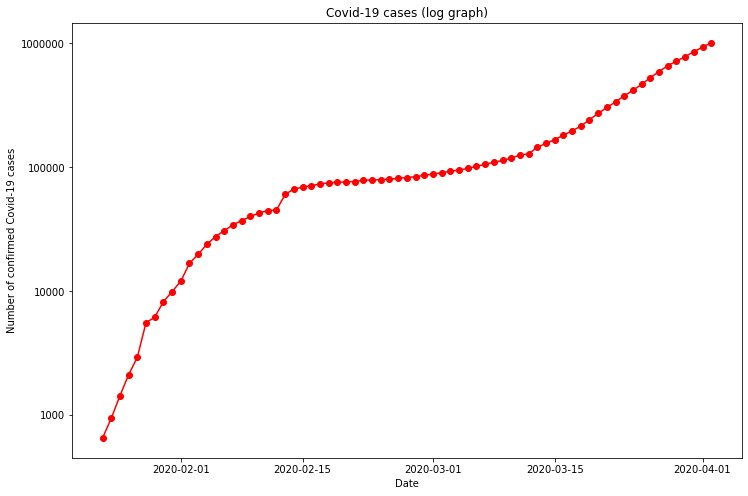

In [83]:
### Display log Covid-19 cases over time
plt.figure(figsize=(12,8))
# define x and y values
x_values=result.Date
y_values = list(result["log_total_cases"])

# plot graph
plt.plot(x_values, y_values, color='r', marker="o", linestyle="-") 

# relabel xticks
y_value_number = [3.0, 4.0, 5.0, 6.0]
y_labels = [int(10**x) for x in y_value_number]
plt.yticks(y_value_number, y_labels)
# relabel graph
plt.title("Covid-19 cases (log graph)")
plt.xlabel("Date")
plt.ylabel("Number of confirmed Covid-19 cases")
plt.savefig('log_cases.png')

In [84]:
import math
import statistics

### define functions from class
def de_mean(xs):
    x_bar = statistics.mean(xs)
    return[x-x_bar for x in xs]

def predict(alpha, beta, x_i):
    return beta*x_i+alpha

def least_squares_fit(xs, ys):
    mean_x=np.mean(xs)
    mean_y=np.mean(ys)
    de_mean_x=[x-mean_x for x in xs]
    de_mean_y=[y-mean_y for y in ys]
    covariance=np.dot(de_mean_x, de_mean_y)/(len(xs)-1)
    std_x=np.std(xs, ddof=1)
    std_y=np.std(ys, ddof=1)
    beta=covariance/std_x**2
    alpha=mean_y-beta*mean_x
    return alpha, beta

def covariance(xs, ys):
    assert len(xs) == len(ys)
    return np.dot(de_mean(xs), de_mean(ys))/(len(xs)-1)

def correlation(xs, ys):
    stdev_x = statistics.stdev(xs)
    stdev_y = statistics.stdev(ys)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(xs,ys)/(stdev_x*stdev_y)
    else:
        return 0

Correlation of Covid-19 cases and tweet_count is -0.6503361804162867
Correlation of Covid-19 cases and retweet_count is -0.6274579035839666
Correlation of Covid-19 cases and favorite_count is -0.6356707528216989


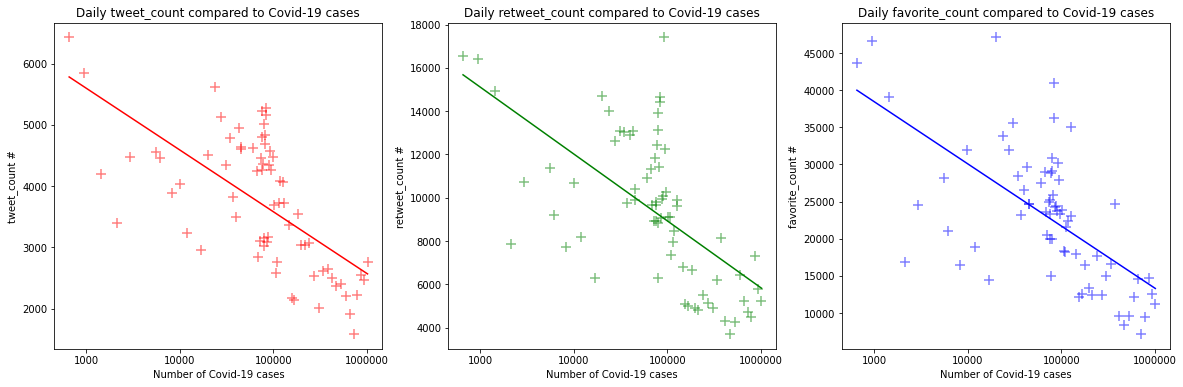

In [85]:
### log Corona cases vs twitter stats

plt.figure(figsize=(20,6))
# keywords for 3 graphs
keywords = ['tweet_count', 'retweet_count', 'favorite_count']
# colors for 3 graphs
colors = ['red', 'green', 'blue']
# draw graphs
for k in range(len(keywords)):
    plt.subplot(1,len(keywords),k+1)
    # define x and y values
    y_values = [int(y) for y in list(result[keywords[k]])]
    x_values = list(result['log_total_cases'])
    # draw graph
    plt.scatter(x_values, y_values,
                s=100,
                c=colors[k],
                marker="+",
                alpha=0.5)
    # rename graph
    plt.title(f"Daily {keywords[k]} compared to Covid-19 cases")
    
    # Project line
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    plt.plot(x_values, y_predict, colors[k])
    # fix x ticks
    x_value_number = [3.0, 4.0, 5.0, 6.0]
    x_labels = [int(10**x) for x in x_value_number]
    plt.xticks(x_value_number, x_labels)
    # label axis
    plt.ylabel(f"{keywords[k]} #")
    plt.xlabel("Number of Covid-19 cases")
    # print corelation score
    print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")
    # save graph
    plt.savefig(f"{keywords[k]}.png")

    
    

Correlation of Covid-19 cases and tweet_count is -0.6366738043873562
Correlation of Covid-19 cases and retweet_count is -0.5929988350488448
Correlation of Covid-19 cases and favorite_count is -0.5953291655156553


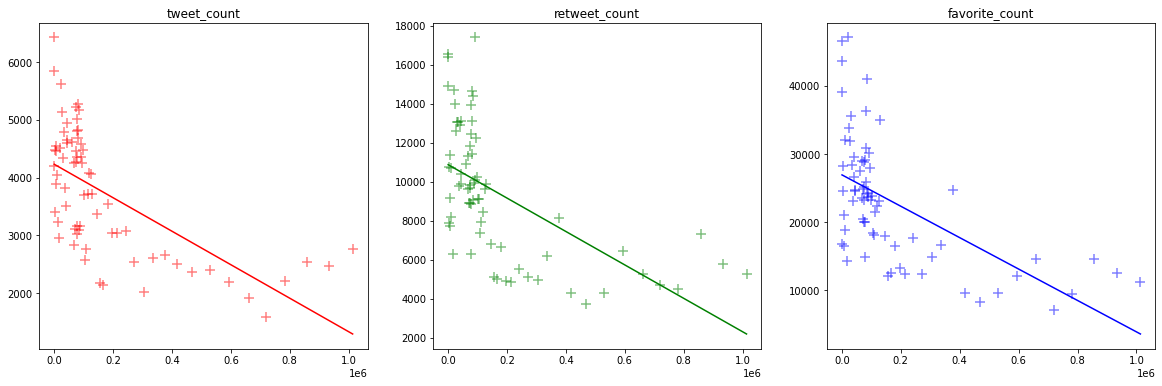

In [86]:
### Corona cases vs twitter stats (non-log, NOT HELPFUL)

plt.figure(figsize=(20,6))
# keywords for 3 graphs
keywords = ['tweet_count', 'retweet_count', 'favorite_count']
# colors for 3 graphs
colors = ['red', 'green', 'blue']
# 
for k in range(len(keywords)):
    plt.subplot(1,len(keywords),k+1)
    y_values = [int(y) for y in list(result[keywords[k]])]
    x_values = list(result['total_cases'])
    plt.title(keywords[k])
    plt.scatter(x_values, y_values,
                s=100,
                c=colors[k],
                marker="+",
                alpha=0.5)
    # Project line
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    # plot projected line
    plt.plot(x_values, y_predict, colors[k])
    # print correlation score
    print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")

Correlation of Covid-19 cases and tweet_count is -0.6664806112576099
Correlation of Covid-19 cases and retweet_count is -0.6423296584087932
Correlation of Covid-19 cases and favorite_count is -0.6450231003282848


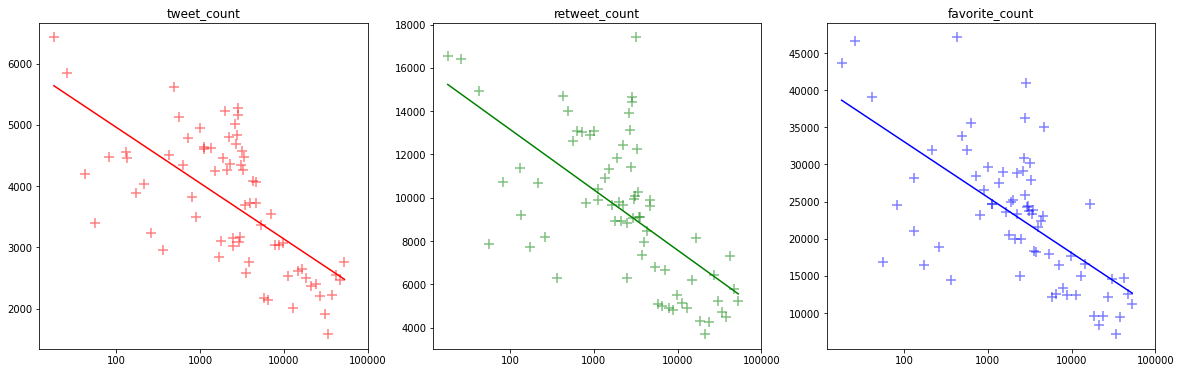

In [87]:
### Corona deaths vs twitter stats (Almost exactly the same as cases, Not Helpfull)

plt.figure(figsize=(20,6))
# list of keywords
keywords = ['tweet_count', 'retweet_count', 'favorite_count']
# list of colors
colors = ['red', 'green', 'blue']
# for each keyword
for k in range(len(keywords)):
    # use a new subplot for each keywors
    plt.subplot(1,len(keywords),k+1)
    # set x and y values
    y_values = [int(y) for y in list(result[keywords[k]])]
    x_values = list(result['log_total_deaths'])
    # make graph
    plt.scatter(x_values, y_values,
                s=100,
                c=colors[k],
                marker="+",
                alpha=0.5)
    # rename graph
    plt.title(keywords[k])
    # Project line
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    # plot projected line
    plt.plot(x_values, y_predict, colors[k])
    
    # change xticks
    x_value_number = [2.0, 3.0, 4.0, 5.0]
    x_labels = [int(10**x) for x in x_value_number]
    plt.xticks(x_value_number, x_labels)
    # print correlation scores
    print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")

    

Correlation of Covid-19 cases and favorite_count is -0.2405087266120832


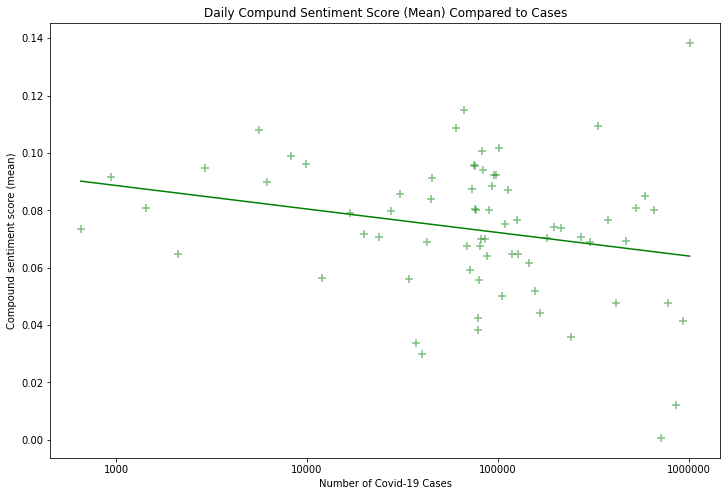

In [88]:
### Sentiments graphs
plt.figure(figsize=(12,8)) 

# set x values
x_values = list(result['log_total_cases'])

# set y values
y_values = [float(y) for y in list(result['sentiment'])]
# draw plot
plt.scatter(x_values, y_values,
            s=50,
            c="g",
            marker="+",
            alpha=0.5)
# project line
alpha, beta = least_squares_fit(x_values, y_values)
y_predict=[predict(alpha, beta, x) for x in x_values]
# draw line
plt.plot(x_values, y_predict, 'g')
# print correlation score
print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")
# rename graph
plt.title('Daily Compund Sentiment Score (Mean) Compared to Cases')
# fix xticks
x_value_number = [3.0, 4.0, 5.0, 6.0]
x_labels = [int(10**x) for x in x_value_number]
plt.xticks(x_value_number, x_labels)
# relabel graph
plt.xlabel("Number of Covid-19 Cases")
plt.ylabel("Compound sentiment score (mean)")
# save graph
plt.savefig("sentiment.png")

In [65]:
# cut out days before 3/12/2020
outside_China= result.iloc[49:]
print(outside_China)

          Date  total_cases  total_deaths  log_total_cases  log_total_deaths  \
49  2020-03-12       128352          4720         5.108403          3.673942   
50  2020-03-13       145205          5404         5.161982          3.732715   
51  2020-03-14       156101          5819         5.193406          3.764848   
52  2020-03-15       167454          6440         5.223896          3.808886   
53  2020-03-16       181574          7126         5.259054          3.852846   
54  2020-03-17       197102          7905         5.294691          3.897902   
55  2020-03-18       214821          8733         5.332077          3.941163   
56  2020-03-19       242570          9867         5.384837          3.994185   
57  2020-03-20       272208         11299         5.434901          4.053040   
58  2020-03-21       304507         12973         5.483597          4.113040   
59  2020-03-22       336953         14651         5.527569          4.165867   
60  2020-03-23       378231         1650

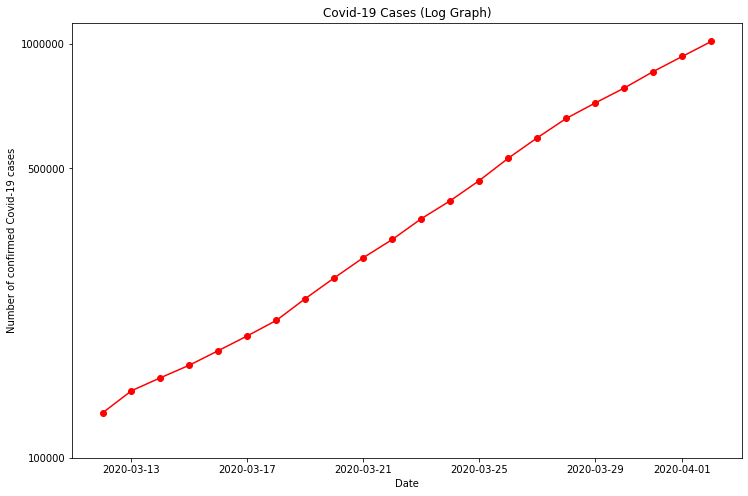

In [89]:
### Log Graph of cases
plt.figure(figsize=(12,8))
# set x values
x_values2=outside_China.Date
# set yvalues
y_values1 = list(outside_China["log_total_cases"])
y_values1=[float(x)for x in y_values1]
# draw graph
plt.plot(x_values2, y_values1, color='r', marker="o", linestyle="-")
# set xticks
y_value_number = [5.0, math.log(500001,10), 6.0]
y_labels = [int(10**x) for x in y_value_number]
plt.yticks(y_value_number, y_labels)
# rename graph
plt.title("Covid-19 Cases (Log Graph)")
# relabel axis'
plt.xlabel("Date")
plt.ylabel("Number of confirmed Covid-19 cases")

# save graph
plt.savefig("cases_after_3-11.png")

Correlation of Covid-19 cases and tweet_count after 3/11/2020 is -0.5538045314610871
Correlation of Covid-19 cases and retweet_count after 3/11/2020 is -0.2689237083911444
Correlation of Covid-19 cases and favorite_count after 3/11/2020 is -0.4810695997062151


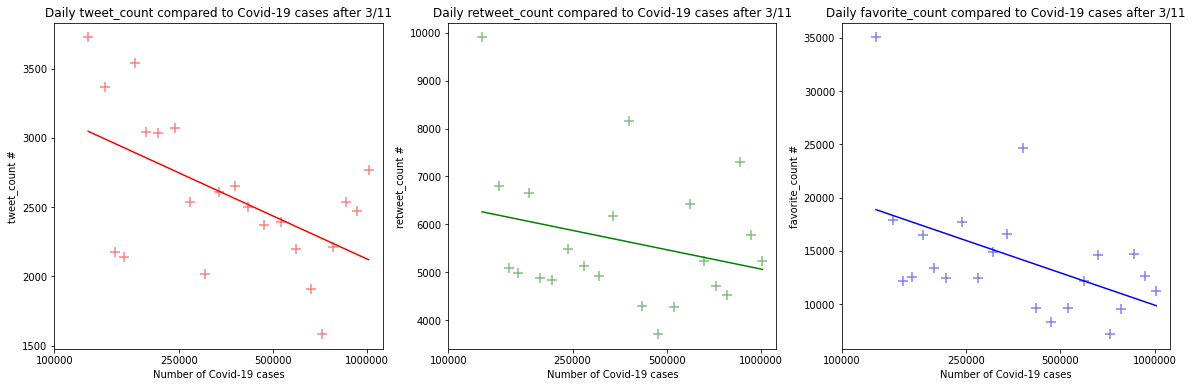

In [77]:
### rerun main graphs with data after 3/11/2020
plt.figure(figsize=(20,6))
# list of keywords for 3 graphs
keywords = ['tweet_count', 'retweet_count', 'favorite_count']
# list of colors for 3 graphs
colors = ['red', 'green', 'blue']
# make a graph for each keyword
for k in range(len(keywords)):
    # make a subplot for each keyword
    plt.subplot(1,len(keywords),k+1)
    # define x and y values
    y_values = [int(y) for y in list(outside_China[keywords[k]])]
    x_values = list(outside_China['log_total_cases'])
    # draw plot
    plt.scatter(x_values, y_values,
                s=100,
                c=colors[k],
                marker="+",
                alpha=0.5)
    # rename graph
    plt.title(f"Daily {keywords[k]} compared to Covid-19 cases after 3/11")
    # Project line
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    # draw line
    plt.plot(x_values, y_predict, colors[k])
    
    # relabel xticks
    x_value_number = [5.0, math.log(250001,10), math.log(500001,10), 6.0]
    x_labels = [int(10**x) for x in x_value_number]
    plt.xticks(x_value_number, x_labels)
    # label x and y values
    plt.ylabel(f"{keywords[k]} #")
    plt.xlabel("Number of Covid-19 cases")
    print(f"Correlation of Covid-19 cases and {keywords[k]} after 3/11/2020 is {correlation(x_values, y_values)}")
    plt.savefig(f"{keywords[k]}_after_3-11.png")
    

Correlation of Covid-19 cases and tweet_count is -0.546556352494929
Correlation of Covid-19 cases and retweet_count is -0.27031795540729764
Correlation of Covid-19 cases and favorite_count is -0.4806871232976416


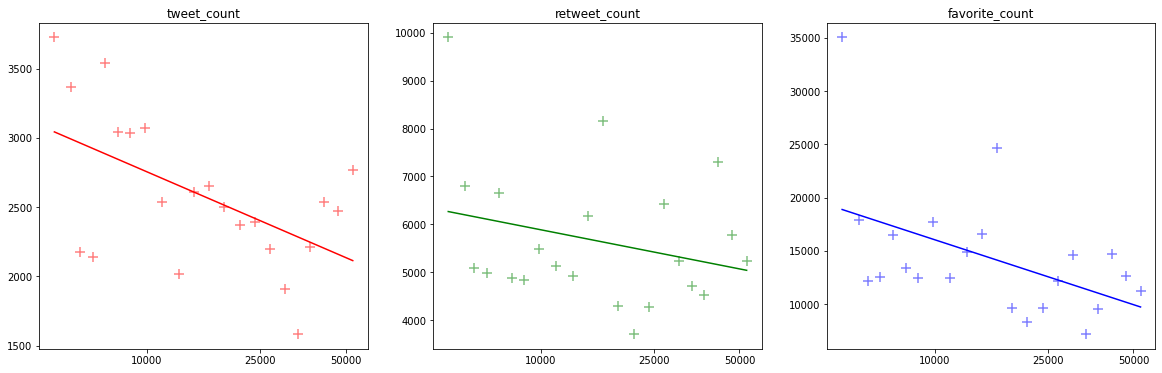

In [90]:
### Almost the same as using cases, no need to include
plt.figure(figsize=(20,6))
# list of keywords
keywords = ['tweet_count', 'retweet_count', 'favorite_count']
# list of colors
colors = ['red', 'green', 'blue']
# for each keyword
for k in range(len(keywords)):
    # use a new subplot for each keywors
    plt.subplot(1,len(keywords),k+1)
    # set x and y values
    y_values = [int(y) for y in list(outside_China[keywords[k]])]
    x_values = list(outside_China['log_total_deaths'])
    # make graph
    plt.scatter(x_values, y_values,
                s=100,
                c=colors[k],
                marker="+",
                alpha=0.5)
    # rename graph
    plt.title(keywords[k])
    # Project line
    alpha, beta = least_squares_fit(x_values, y_values)
    y_predict=[predict(alpha, beta, x) for x in x_values]
    # plot projected line
    plt.plot(x_values, y_predict, colors[k])
    
    # change xticks
    x_value_number = [4.0,math.log(25001,10), math.log(50001,10)]
    x_labels = [int(10**x) for x in x_value_number]
    plt.xticks(x_value_number, x_labels)
    # print correlation scores
    print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")


Correlation of Covid-19 cases and favorite_count is -0.008857515082647153


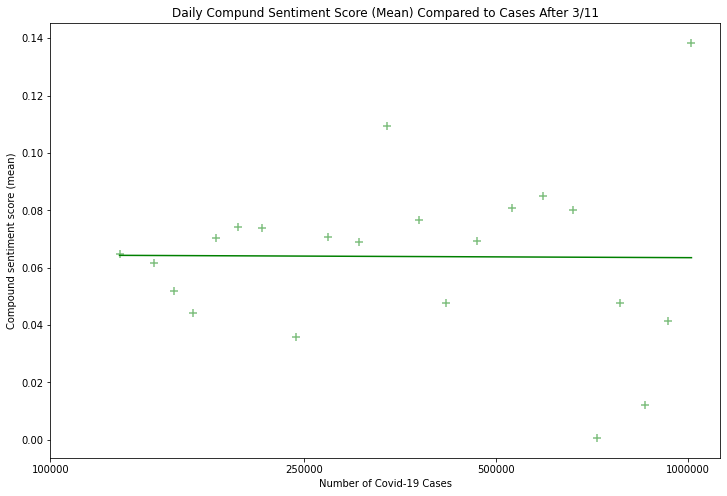

In [91]:
### Sentiments graphs adter 3/11
plt.figure(figsize=(12,8)) 

# set x values
x_values = list(outside_China['log_total_cases'])

# set y values
y_values = [float(y) for y in list(outside_China['sentiment'])]
# draw plot
plt.scatter(x_values, y_values,
            s=50,
            c="g",
            marker="+",
            alpha=0.5)
# project line
alpha, beta = least_squares_fit(x_values, y_values)
y_predict=[predict(alpha, beta, x) for x in x_values]
# draw line
plt.plot(x_values, y_predict, 'g')
# print correlation score
print(f"Correlation of Covid-19 cases and {keywords[k]} is {correlation(x_values, y_values)}")
# rename graph
plt.title('Daily Compund Sentiment Score (Mean) Compared to Cases After 3/11')
# fix xticks
x_value_number = [5.0, math.log(250001,10), math.log(500001,10), 6.0]
x_labels = [int(10**x) for x in x_value_number]
plt.xticks(x_value_number, x_labels)
# relabel graph
plt.xlabel("Number of Covid-19 Cases")
plt.ylabel("Compound sentiment score (mean)")
# save graph
plt.savefig("Sentiments_after_3-11.png")